In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import bambi as bmb
import theano
import arviz as az
import os
cwd = os.getcwd() # Get direction
import warnings
warnings.filterwarnings('ignore')
import bayes_ame as ame
import R2_Bayes as r2

In [2]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')

In [3]:
#DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF['mean_farmsize']= DF['ACRES OPERATED']/DF['NUMBER OF OPERATIONS']
DF['tavg_sd']= DF['tavg_coeff']* DF['tavg_mean']
DF['pcp_sd']= DF['pcp_mm_coeff']* DF['pcp_mm_mean']
DF['edd_sd']= DF['edd_coeff']* DF['edd_mean']
DF['pcpdays_sd']= DF['pcpdays_coeff']* DF['pcpdays_mean']

In [4]:
DF= DF[DF['state_name']!= 'ALASKA']
DF= DF[DF['state_name']!= 'HAWAII']

In [5]:
print((DF['mean_farmincome'][(DF['farm_class']=='Small') & (DF['year']==2022)]).mean())
print((DF['mean_farmincome'][(DF['farm_class']=='Medium') & (DF['year']==2022)]).mean())

20857.928009864565
29318.19492352866


In [6]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['farm_class']= dfy.variables.str[-2:-1]
    
    return dfy

In [7]:
DF.columns

Index(['year', 'state_name', 'state_fips_code', 'domaincat_desc',
       'ACRES OPERATED', 'NUMBER OF OPERATIONS', 'farmcat', 'lower_bound',
       'upper_bound', '(EXCL CRP) - ACRES', 'DRAINED BY TILE - ACRES',
       '(EXCL CRP) - NUMBER OF OPERATIONS',
       'DRAINED BY TILE - NUMBER OF OPERATIONS', 'CROP INSURANCE - ACRES',
       'CROP INSURANCE - NUMBER OF OPERATIONS',
       'IRRIGATED - NUMBER OF OPERATIONS_x', 'RENTED FROM OTHERS_x',
       'RENTED FROM OTHERS_y', 'OWNED_x', 'OWNED_y', 'IRRIGATED - ACRES',
       'IRRIGATED - NUMBER OF OPERATIONS_y',
       'NET INCOME, MEASURED IN $ / OPERATION', 'FEDERAL - RECEIPTS',
       'FEDERAL - OPERATIONS WITH RECEIPTS', 'tot_income', 'income_ope',
       'STATE & LOCAL - RECEIPTS', 'STATE & LOCAL - OPERATIONS WITH RECEIPTS',
       'HIRED - EXPENSE', 'HIRED - OPERATIONS WITH EXPENSE',
       'CONTRACT - EXPENSE', 'CONTRACT - OPERATIONS WITH EXPENSE',
       'EXPENSE, MEASURED IN $', 'OPERATIONS WITH EXPENSE',
       'MACHINERY TOTAL

### Prepare data for Bayesian Models

In [8]:
DF.dropna(axis=0, how='any',subset=['cover_crops','mean_farmsize',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'edd_mean','pcpdays_mean',
          'tavg_sd', 'pcp_sd'], inplace=True)

In [9]:
DF

,year,state_name,state_fips_code,domaincat_desc,ACRES OPERATED,NUMBER OF OPERATIONS,farmcat,lower_bound,upper_bound,(EXCL CRP) - ACRES,...,veggies_shareope,fruit_shareope,cattle_shareope,year_2017,year_2022,mean_farmsize,tavg_sd,pcp_sd,edd_sd,pcpdays_sd
0,2012,ALABAMA,1,AREA OPERATED: (1.0 TO 9.9 ACRES),14379.0,2919,1-10,1,9.0,139.0,...,0.079822,0.073998,0.220281,0,0,4.926002,0.683609,290.936231,15.185549,4.684287
1,2012,ALABAMA,1,AREA OPERATED: (10.0 TO 49.9 ACRES),362197.0,13267,10-50,10,49.0,2651.0,...,0.035803,0.036858,0.373785,0,0,27.300595,0.683609,290.936231,15.185549,4.684287
2,2012,ALABAMA,1,AREA OPERATED: (50.0 TO 69.9 ACRES),246346.0,4235,50-70,50,69.0,1984.0,...,0.016765,0.023849,0.452893,0,0,58.169067,0.683609,290.936231,15.185549,4.684287
3,2012,ALABAMA,1,AREA OPERATED: (70.0 TO 99.9 ACRES),377435.0,4605,70-100,70,99.0,2921.0,...,0.018458,0.022150,0.488599,0,0,81.961998,0.683609,290.936231,15.185549,4.684287
4,2012,ALABAMA,1,AREA OPERATED: (100 TO 139 ACRES),500043.0,4342,100-140,100,139.0,3569.0,...,0.019116,0.024413,0.463611,0,0,115.164210,0.683609,290.936231,15.185549,4.684287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,2022,WYOMING,56,AREA OPERATED: (220 TO 259 ACRES),55708.0,234,220-260,220,259.0,641.0,...,0.000000,0.000000,0.363248,0,1,238.068376,0.510042,85.053539,17.611999,0.449519
1724,2022,WYOMING,56,AREA OPERATED: (260 TO 499 ACRES),320538.0,887,260-500,260,499.0,2525.0,...,0.001127,0.000000,0.394589,0,1,361.373168,0.510042,85.053539,17.611999,0.449519
1725,2022,WYOMING,56,AREA OPERATED: (500 TO 999 ACRES),619090.0,882,500-1K,500,999.0,5269.0,...,0.000000,0.001134,0.460317,0,1,701.916100,0.510042,85.053539,17.611999,0.449519
1726,2022,WYOMING,56,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1102112.0,798,1K-2K,1000,1999.0,6328.0,...,0.000000,0.000000,0.527569,0,1,1381.092732,0.510042,85.053539,17.611999,0.449519


In [10]:
# Keep counties with at least 2 observations
DF.sort_values(by= ['state_fips_code','farmcat','year'], inplace=True)
DF['cons']=1
DF['times']= DF.groupby(['state_fips_code','farmcat'])['cons'].transform(sum)

In [41]:
## Remove inf vals
DF.replace([np.inf, -np.inf], np.nan, inplace=True)
## Selected variables for inference
fe_vars= ['irrigated_ope','mean_farmsize',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'edd_mean','pcpdays_mean',
          'tavg_sd', 'pcp_sd', 'tavg_z', 'pcp_mm_z']
DF1= DF[['times','state_fips_code','year','farmcat','farm_class','class','year_2017', 'year_2022']+fe_vars]
DF1= DF1[DF1['times']>1] # select farm groups with more that 2 years of data

#Standardize variables within farm size and state groups
for x in fe_vars:    
    DF1[x+'_fe']= (DF1[x] - DF1.groupby(['state_fips_code','farmcat'])[x].transform('mean'))/(DF1.groupby(['state_fips_code','farmcat'])[x].transform('std'))
    


(array([ 97.,  36.,  36.,  24.,  39.,  22.,  51.,  32.,  12.,  62.,  54.,
          0., 154.,   0.,  24.,  54.,  12.,  22.,  10.,  27.,  36.,  10.,
         39.,   0.,  12.,  24.,  24.,   0.,  12.,  24.,   0.,  39.,  12.,
         22.,   0.,  12.,   0.,  24.,   0.,  12.,  46.,  14.,  51.,  24.,
         12.,  24.,  24.,  51.,  61., 211.]),
 array([-1.15468633e+00, -1.10849863e+00, -1.06231094e+00, -1.01612325e+00,
        -9.69935552e-01, -9.23747858e-01, -8.77560164e-01, -8.31372470e-01,
        -7.85184776e-01, -7.38997082e-01, -6.92809388e-01, -6.46621694e-01,
        -6.00434000e-01, -5.54246306e-01, -5.08058612e-01, -4.61870918e-01,
        -4.15683224e-01, -3.69495530e-01, -3.23307836e-01, -2.77120142e-01,
        -2.30932448e-01, -1.84744754e-01, -1.38557060e-01, -9.23693665e-02,
        -4.61816725e-02,  6.02150004e-06,  4.61937155e-02,  9.23814095e-02,
         1.38569103e-01,  1.84756797e-01,  2.30944491e-01,  2.77132185e-01,
         3.23319879e-01,  3.69507573e-01,  4.15695

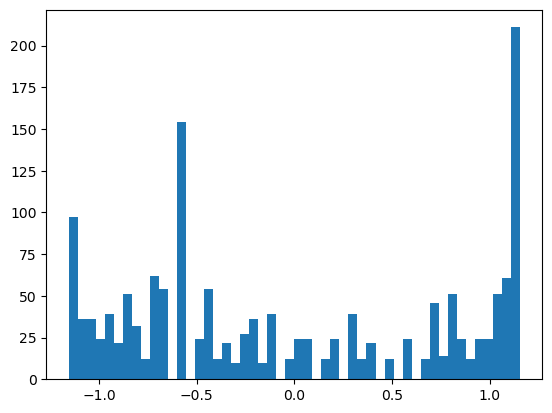

In [12]:
plt.hist(DF1['tavg_sd_fe'], bins=50)

In [13]:
DF1

,times,state_fips_code,year,farmcat,farm_class,class,year_2017,year_2022,irrigated_ope,mean_farmsize,...,edd_mean_fe,pcpdays_mean_fe,tavg_sd_fe,pcp_sd_fe,edd_sd_fe,pcpdays_sd_fe,tavg_z_fe,pcp_mm_z_fe,edd_z_fe,pcpdays_z_fe
0,3,1,2012,1-10,Small,0,0,0,0.109969,4.926002,...,-0.795682,-1.146333,1.154456,1.022485,-1.111816,0.947722,0.914449,-0.900068,-0.851839,-1.152642
576,3,1,2017,1-10,Small,0,1,0,0.104872,4.965318,...,-0.326843,0.452998,-0.556668,-0.046599,0.285909,0.097425,-1.067828,-0.176391,-0.249194,0.636008
1152,3,1,2022,1-10,Small,0,0,1,0.142052,4.857948,...,1.122525,0.693335,-0.597789,-0.975886,0.825907,-1.045147,0.153379,1.076459,1.101033,0.516634
1,3,1,2012,10-50,Small,0,0,0,0.040778,27.300595,...,-0.795682,-1.146333,1.154456,1.022485,-1.111816,0.947722,0.914449,-0.900068,-0.851839,-1.152642
577,3,1,2017,10-50,Small,0,1,0,0.045106,27.055630,...,-0.326843,0.452998,-0.556668,-0.046599,0.285909,0.097425,-1.067828,-0.176391,-0.249194,0.636008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,3,56,2017,70-100,Small,0,1,0,0.569584,81.278336,...,-0.285703,0.849228,-0.753974,-1.129887,-1.131138,0.783805,0.363035,1.059928,-0.297725,0.510567
1719,3,56,2022,70-100,Small,0,0,1,0.479542,81.194763,...,1.111758,-1.102190,-0.380405,0.358747,0.766554,-1.126230,0.767774,-0.926719,1.115051,-1.152218
575,3,56,2012,>2K,Large,2,0,0,0.473729,11786.334900,...,-0.826055,0.252962,1.134379,0.771140,0.364584,0.342425,-1.130809,-0.133209,-0.817326,0.641651
1151,3,56,2017,>2K,Large,2,1,0,0.499092,11978.582198,...,-0.285703,0.849228,-0.753974,-1.129887,-1.131138,0.783805,0.363035,1.059928,-0.297725,0.510567


# Pooled model

In [42]:
# Priors
st_sd=1
priorsp = {
    'Intercept': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'mean_farmsize_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'insured_farms_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'tavg_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'pcp_mm_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'edd_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'pcpdays_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'edd_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'pcpdays_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= st_sd)
}
## Pooled model
modelp = bmb.Model("irrigated_ope_fe ~ 1+ (mean_farmsize_fe)\
                    +(insured_farms_fe)+\
       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+\
       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+\
       (veggies_shareope_fe)+(cattle_shareope_fe)+\
       (edd_mean_fe)+(pcpdays_mean_fe)+\
       (tavg_sd_fe) + (pcp_sd_fe) +(tavg_z_fe)+ (pcp_mm_z_fe)+\
       (year_2017)+(year_2022)", 
                     DF1, priors= priorsp, dropna=True)
modelp

Automatically removing 53/1588 rows from the dataset.


Formula: irrigated_ope_fe ~ 1+ (mean_farmsize_fe)                    +(insured_farms_fe)+       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+       (veggies_shareope_fe)+(cattle_shareope_fe)+       (edd_mean_fe)+(pcpdays_mean_fe)+       (tavg_sd_fe) + (pcp_sd_fe) +(tavg_z_fe)+ (pcp_mm_z_fe)+       (year_2017)+(year_2022)
Family name: Gaussian
Link: identity
Observations: 1535
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 1)
    mean_farmsize_fe ~ Laplace(mu: 0, b: 1)
    insured_farms_fe ~ Laplace(mu: 0, b: 1)
    fed_income_fe ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe ~ Laplace(mu: 0, b: 1)
    labor_expense_fe ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe ~ Laplace(mu: 0, b: 1)
    rented_land_fe ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe ~ Laplace(mu: 0, b: 1)
    veggies_shareope_fe ~ Laplace(mu: 0, b: 1)
    cattle_shareope_fe ~ Laplace(mu: 0, b: 1)
    edd_mean_fe ~ Laplace(mu: 0

In [43]:
tracep = modelp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [irrigated_ope_fe_sigma, Intercept, year_2022, year_2017, pcp_mm_z_fe, tavg_z_fe, pcp_sd_fe, tavg_sd_fe, pcpdays_mean_fe, edd_mean_fe, cattle_shareope_fe, veggies_shareope_fe, grains_shareope_fe, rented_land_fe, machinery_asset_fe, labor_expense_fe, statepay_ope_fe, fed_income_fe, insured_farms_fe, mean_farmsize_fe]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.


In [17]:
az.loo(tracep)

Computed from 4000 posterior samples and 1535 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1695.55    20.90
p_loo       23.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1535  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [44]:
az.summary(tracep)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.078,0.066,-0.047,0.202,0.001,0.001,2068.0,2228.0,1.0
mean_farmsize_fe,0.000,0.023,-0.042,0.044,0.000,0.000,4568.0,2878.0,1.0
insured_farms_fe,0.179,0.029,0.126,0.234,0.000,0.000,3598.0,2865.0,1.0
fed_income_fe,-0.039,0.028,-0.089,0.014,0.000,0.000,3326.0,2762.0,1.0
statepay_ope_fe,0.102,0.024,0.058,0.145,0.000,0.000,3539.0,3009.0,1.0
labor_expense_fe,0.056,0.027,0.005,0.107,0.000,0.000,4289.0,3171.0,1.0
machinery_asset_fe,0.049,0.026,-0.002,0.094,0.000,0.000,3735.0,2509.0,1.0
rented_land_fe,0.025,0.029,-0.032,0.077,0.000,0.000,3750.0,3190.0,1.0
grains_shareope_fe,0.073,0.025,0.026,0.120,0.000,0.000,4022.0,2953.0,1.0
veggies_shareope_fe,0.043,0.024,-0.002,0.087,0.000,0.000,4544.0,2908.0,1.0


In [65]:

DF1['cons']=1

selvars=['cons', 'mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022']


varspost= ['Intercept','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['irrigated_ope_fe','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022'], inplace=True)


In [63]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean, 'identity',tracep, 'irrigated_ope_fe',selvars,varspost, False, x,4,1000,x)

In [64]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.2128167787478162
Lower CI: 0.18115140558957873
Upper CI: 0.24370530578352653


In [46]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.99).values())
print(az.hdi(tracep,var_names=varspost[12:], hdi_prob = 0.99).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.08603 0.2497
    mean_farmsize_fe     (hdi) float64 -0.05837 0.06048
    insured_farms_fe     (hdi) float64 0.1006 0.2476
    fed_income_fe        (hdi) float64 -0.1056 0.03279
    statepay_ope_fe      (hdi) float64 0.04295 0.1635
    labor_expense_fe     (hdi) float64 -0.01483 0.1256
    machinery_asset_fe   (hdi) float64 -0.0162 0.1151
    rented_land_fe       (hdi) float64 -0.05072 0.09923
    grains_shareope_fe   (hdi) float64 0.009683 0.1343
    veggies_shareope_fe  (hdi) float64 -0.0199 0.09924
    cattle_shareope_fe   (hdi) float64 -0.2091 -0.07068
    edd_mean_fe          (hdi) float64 0.3407 0.6238)
ValuesView(<xarray.Dataset>
Dimensions:          (hdi: 2)
Coordinates:
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    pcpdays_mean_fe  (hdi) float64 -0.0778 0.1214
    tavg_sd_fe

In [47]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.90).values())
print(az.hdi(tracep,var_names=varspost[12:], hdi_prob = 0.90).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.02617 0.1914
    mean_farmsize_fe     (hdi) float64 -0.0387 0.03602
    insured_farms_fe     (hdi) float64 0.1294 0.2255
    fed_income_fe        (hdi) float64 -0.08196 0.00837
    statepay_ope_fe      (hdi) float64 0.06288 0.1406
    labor_expense_fe     (hdi) float64 0.01212 0.1014
    machinery_asset_fe   (hdi) float64 0.008453 0.09228
    rented_land_fe       (hdi) float64 -0.0244 0.07189
    grains_shareope_fe   (hdi) float64 0.03172 0.114
    veggies_shareope_fe  (hdi) float64 0.003847 0.08131
    cattle_shareope_fe   (hdi) float64 -0.1834 -0.09416
    edd_mean_fe          (hdi) float64 0.3946 0.5787)
ValuesView(<xarray.Dataset>
Dimensions:          (hdi: 2)
Coordinates:
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    pcpdays_mean_fe  (hdi) float64 -0.04272 0.08274
    tavg_sd_f

# Hierarchical model 

In [48]:
st_sd= 1 #bmb.Prior("HalfCauchy", beta= 1)


priorsc = {
    '1|class': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'mean_farmsize_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'insured_farms_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_sd_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_sd_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= 1)
}


In [49]:
model = bmb.Model("irrigated_ope_fe ~ 0+(1|class)+(mean_farmsize_fe|class)+ (insured_farms_fe|class)+\
       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+\
       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+\
       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+\
       (edd_mean_fe|class)+(pcpdays_mean_fe|class)+\
       (tavg_sd_fe|class) + (pcp_sd_fe|class)+ (tavg_z_fe|class)+ (pcp_mm_z_fe|class) +\
       (year_2017|class)+ (year_2022|class)", 
        DF1, priors= priorsc, dropna=True)
#
model

Formula: irrigated_ope_fe ~ 0+(1|class)+(mean_farmsize_fe|class)+ (insured_farms_fe|class)+       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+       (edd_mean_fe|class)+(pcpdays_mean_fe|class)+       (tavg_sd_fe|class) + (pcp_sd_fe|class)+ (tavg_z_fe|class)+ (pcp_mm_z_fe|class) +       (year_2017|class)+ (year_2022|class)
Family name: Gaussian
Link: identity
Observations: 1535
Priors:
  Group-level effects
    1|class ~ Normal(mu: 0, sigma: 1)
    mean_farmsize_fe|class ~ Laplace(mu: 0, b: 1)
    insured_farms_fe|class ~ Laplace(mu: 0, b: 1)
    fed_income_fe|class ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe|class ~ Laplace(mu: 0, b: 1)
    labor_expense_fe|class ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe|class ~ Laplace(mu: 0, b: 1)
    rented_land_fe|class ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe|class ~ 

In [50]:
trace = model.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [irrigated_ope_fe_sigma, year_2022|class, year_2017|class, pcp_mm_z_fe|class, tavg_z_fe|class, pcp_sd_fe|class, tavg_sd_fe|class, pcpdays_mean_fe|class, edd_mean_fe|class, cattle_shareope_fe|class, veggies_shareope_fe|class, grains_shareope_fe|class, rented_land_fe|class, machinery_asset_fe|class, labor_expense_fe|class, statepay_ope_fe|class, fed_income_fe|class, insured_farms_fe|class, mean_farmsize_fe|class, 1|class]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 379 seconds.


In [51]:
df= dfsummary(trace)
df[df['farm_class']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[0],0.059,0.114,-0.157,0.268,0.004,0.003,1064.0,1390.0,1.0,1|class[0],0
mean_farmsize_fe|class[0],-0.016,0.040,-0.087,0.059,0.001,0.001,4547.0,2786.0,1.0,mean_farmsize_fe|class[0],0
insured_farms_fe|class[0],0.169,0.054,0.070,0.271,0.001,0.001,3701.0,3259.0,1.0,insured_farms_fe|class[0],0
fed_income_fe|class[0],0.031,0.046,-0.053,0.116,0.001,0.001,4193.0,3388.0,1.0,fed_income_fe|class[0],0
statepay_ope_fe|class[0],0.073,0.042,-0.013,0.145,0.001,0.001,4096.0,2879.0,1.0,statepay_ope_fe|class[0],0
labor_expense_fe|class[0],0.018,0.041,-0.058,0.094,0.001,0.001,4858.0,3162.0,1.0,labor_expense_fe|class[0],0
machinery_asset_fe|class[0],0.027,0.043,-0.049,0.110,0.001,0.001,3981.0,2917.0,1.0,machinery_asset_fe|class[0],0
rented_land_fe|class[0],-0.028,0.057,-0.136,0.079,0.001,0.001,3170.0,2446.0,1.0,rented_land_fe|class[0],0
grains_shareope_fe|class[0],0.059,0.042,-0.022,0.136,0.001,0.000,4678.0,3031.0,1.0,grains_shareope_fe|class[0],0
veggies_shareope_fe|class[0],0.087,0.040,0.013,0.162,0.001,0.000,5060.0,3326.0,1.0,veggies_shareope_fe|class[0],0


In [52]:
df[df['farm_class']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[1],0.178,0.118,-0.040,0.394,0.003,0.002,1307.0,2319.0,1.0,1|class[1],1
mean_farmsize_fe|class[1],-0.018,0.040,-0.094,0.054,0.001,0.001,5227.0,3100.0,1.0,mean_farmsize_fe|class[1],1
insured_farms_fe|class[1],0.118,0.050,0.033,0.217,0.001,0.001,4123.0,3380.0,1.0,insured_farms_fe|class[1],1
fed_income_fe|class[1],-0.070,0.048,-0.168,0.011,0.001,0.001,4594.0,3094.0,1.0,fed_income_fe|class[1],1
statepay_ope_fe|class[1],0.039,0.042,-0.034,0.120,0.001,0.001,5189.0,3043.0,1.0,statepay_ope_fe|class[1],1
labor_expense_fe|class[1],0.133,0.048,0.038,0.218,0.001,0.001,4369.0,2922.0,1.0,labor_expense_fe|class[1],1
machinery_asset_fe|class[1],-0.006,0.045,-0.096,0.072,0.001,0.001,4550.0,3251.0,1.0,machinery_asset_fe|class[1],1
rented_land_fe|class[1],-0.044,0.054,-0.152,0.049,0.001,0.001,4186.0,2851.0,1.0,rented_land_fe|class[1],1
grains_shareope_fe|class[1],0.125,0.044,0.042,0.208,0.001,0.001,4052.0,3191.0,1.0,grains_shareope_fe|class[1],1
veggies_shareope_fe|class[1],0.008,0.041,-0.069,0.085,0.001,0.001,5894.0,3036.0,1.0,veggies_shareope_fe|class[1],1


In [53]:
df[df['farm_class']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[2],-0.015,0.117,-0.229,0.208,0.003,0.002,1260.0,1942.0,1.0,1|class[2],2
mean_farmsize_fe|class[2],0.075,0.041,0.002,0.160,0.001,0.001,4461.0,2730.0,1.0,mean_farmsize_fe|class[2],2
insured_farms_fe|class[2],0.145,0.050,0.049,0.238,0.001,0.001,4025.0,3018.0,1.0,insured_farms_fe|class[2],2
fed_income_fe|class[2],-0.132,0.050,-0.231,-0.045,0.001,0.001,3058.0,3024.0,1.0,fed_income_fe|class[2],2
statepay_ope_fe|class[2],0.172,0.042,0.092,0.249,0.001,0.000,4543.0,3081.0,1.0,statepay_ope_fe|class[2],2
labor_expense_fe|class[2],0.063,0.056,-0.042,0.167,0.001,0.001,3438.0,2744.0,1.0,labor_expense_fe|class[2],2
machinery_asset_fe|class[2],0.202,0.050,0.105,0.296,0.001,0.001,3571.0,3015.0,1.0,machinery_asset_fe|class[2],2
rented_land_fe|class[2],0.160,0.047,0.076,0.251,0.001,0.001,4133.0,2949.0,1.0,rented_land_fe|class[2],2
grains_shareope_fe|class[2],0.061,0.045,-0.024,0.147,0.001,0.001,4376.0,3395.0,1.0,grains_shareope_fe|class[2],2
veggies_shareope_fe|class[2],0.073,0.042,-0.005,0.155,0.001,0.000,4867.0,2688.0,1.0,veggies_shareope_fe|class[2],2


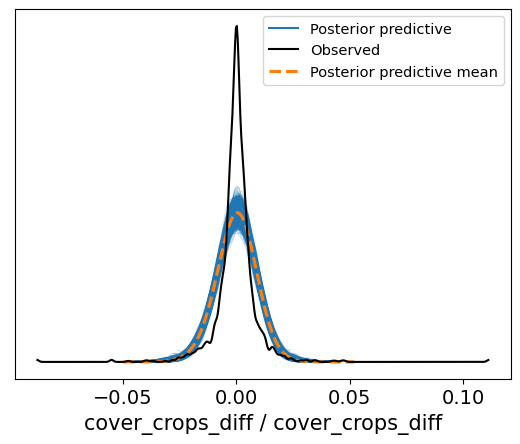

In [110]:
model.predict(trace, kind="pps")
az.plot_ppc(trace);

In [30]:
az.loo(trace)

Computed from 4000 posterior samples and 1588 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  5652.21   133.17
p_loo      116.01        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1579   99.4%
 (0.5, 0.7]   (ok)          4    0.3%
   (0.7, 1]   (bad)         3    0.2%
   (1, Inf)   (very bad)    2    0.1%

## R2 

In [54]:

DF1['cons']=1
selvars=['cons','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe','tavg_sd_fe', 'pcp_sd_fe',
         'tavg_z_fe','pcp_mm_z_fe','year_2017','year_2022']


varspost= ['1|class','mean_farmsize_fe|class',
        'insured_farms_fe|class','fed_income_fe|class', 'statepay_ope_fe|class', 
        'labor_expense_fe|class','machinery_asset_fe|class', 'rented_land_fe|class',
        'grains_shareope_fe|class', 'veggies_shareope_fe|class','cattle_shareope_fe|class',
        'edd_mean_fe|class','pcpdays_mean_fe|class',
        'tavg_sd_fe|class', 'pcp_sd_fe|class','tavg_z_fe|class','pcp_mm_z_fe|class',
           'year_2017|class','year_2022|class']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['irrigated_ope_fe','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe','pcp_mm_z_fe','year_2017','year_2022'], inplace=True)


In [40]:
mean, lci, uci= r2.Bayesian_Rsquared(DF1_clean,'identity', trace, 'irrigated_ope_fe',selvars,varspost, True, 'class', 4, 1000, 3)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.20053022146147517
Lower CI: 0.16888852133069834
Upper CI: 0.23197178012713626


In [59]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='0'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='0'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '0'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.2198 0.3846
    mean_farmsize_fe|class     (hdi) float64 -0.1182 0.08151
    insured_farms_fe|class     (hdi) float64 0.02942 0.2959
    fed_income_fe|class        (hdi) float64 -0.08105 0.1479
    statepay_ope_fe|class      (hdi) float64 -0.04004 0.1798
    labor_expense_fe|class     (hdi) float64 -0.08539 0.1318
    machinery_asset_fe|class   (hdi) float64 -0.08212 0.1354
    rented_land_fe|class       (hdi) float64 -0.1617 0.1249
    grains_shareope_fe|class   (hdi) float64 -0.04833 0.163
    veggies_shareope_fe|class  (hdi) float64 -0.01676 0.1825
    cattle_shareope_fe|class   (hdi) float64 -0.2149 0.03969
    edd_mean_fe|class          (hdi) float64 0.1981 0.6883
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_group_

In [60]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='1'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='1'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '1'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.09965 0.5157
    mean_farmsize_fe|class     (hdi) float64 -0.1203 0.083
    insured_farms_fe|class     (hdi) float64 -0.004024 0.2494
    fed_income_fe|class        (hdi) float64 -0.1945 0.04927
    statepay_ope_fe|class      (hdi) float64 -0.06632 0.149
    labor_expense_fe|class     (hdi) float64 0.01468 0.2546
    machinery_asset_fe|class   (hdi) float64 -0.124 0.1065
    rented_land_fe|class       (hdi) float64 -0.1815 0.1063
    grains_shareope_fe|class   (hdi) float64 0.01582 0.2395
    veggies_shareope_fe|class  (hdi) float64 -0.102 0.1121
    cattle_shareope_fe|class   (hdi) float64 -0.1609 0.07992
    edd_mean_fe|class          (hdi) float64 0.3894 0.865
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_group_factor

In [61]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='2'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='2'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '2'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.2966 0.2833
    mean_farmsize_fe|class     (hdi) float64 -0.04079 0.1789
    insured_farms_fe|class     (hdi) float64 0.02382 0.2735
    fed_income_fe|class        (hdi) float64 -0.256 0.002956
    statepay_ope_fe|class      (hdi) float64 0.05812 0.2756
    labor_expense_fe|class     (hdi) float64 -0.07917 0.2003
    machinery_asset_fe|class   (hdi) float64 0.07858 0.333
    rented_land_fe|class       (hdi) float64 0.03962 0.2817
    grains_shareope_fe|class   (hdi) float64 -0.05073 0.184
    veggies_shareope_fe|class  (hdi) float64 -0.0422 0.1804
    cattle_shareope_fe|class   (hdi) float64 -0.2759 -0.03353
    edd_mean_fe|class          (hdi) float64 0.0511 0.5614
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_group_fac

### Model comparison

In [58]:
az.compare({"main": trace, "pooled": tracep})#, 'state effects': trace_cc2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,-1686.318723,55.932393,0.000000,0.639711,22.119414,0.000000,False,log
pooled,1,-1698.724871,19.189426,12.406148,0.360289,20.831617,9.927012,False,log


In [66]:
print('Lower Bound: ', 12.406148-9.927012*2.92)
print('Upper Bound: ', 12.406148+9.927012*2.92)


Lower Bound:  -16.58072704
Upper Bound:  41.393023039999996


In [133]:
#ppc = pm.sample_posterior_predictive(trace_cc, samples=1000, model=modelcc)
#post_samples = np.asarray(ppc['cover_crops'])